# PII Documents Classification using Transfer Learning

Author: Nidhish Kumar

Last Updated: 03-06-2023

## Metadata of the Dataset

The dataset contains 600+ images distributed among 6 classes.

Each image belongs to one of the following classes:

- Aadhar Card
- Pan Card
- Voter ID
- Passport
- Driving License
- Utility

**NOTE: We are not using the utility class in this notebook.**

## Downloading the Dataset

We download the [PII image dataset](https://www.kaggle.com/datasets/mehaksingal/personal-identification-image-dataset-for-india) for training the model.

In [4]:
!kaggle datasets download -d mehaksingal/personal-identification-image-dataset-for-india

 86% 62.0M/72.4M [00:00<00:00, 112MB/s] 
100% 72.4M/72.4M [00:00<00:00, 76.5MB/s]


## Importing necessary modules

We import the following modules to read the data, visulaize it and create models:

- **Matplotlib** to visualize the data.
- **PIL** to read and remove some images having bad format.
- **TensorFlow** to create models.

In [6]:
import os

import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np

from PIL import Image

import tensorflow as tf

tf.random.set_seed(1)

In [7]:
# checking GPU

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
! nvidia-smi

Sat Jun  3 14:32:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Exploring the Dataset

In [20]:
parent_dir = "/content/PIIDataset"

HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 16

n_classes = 5

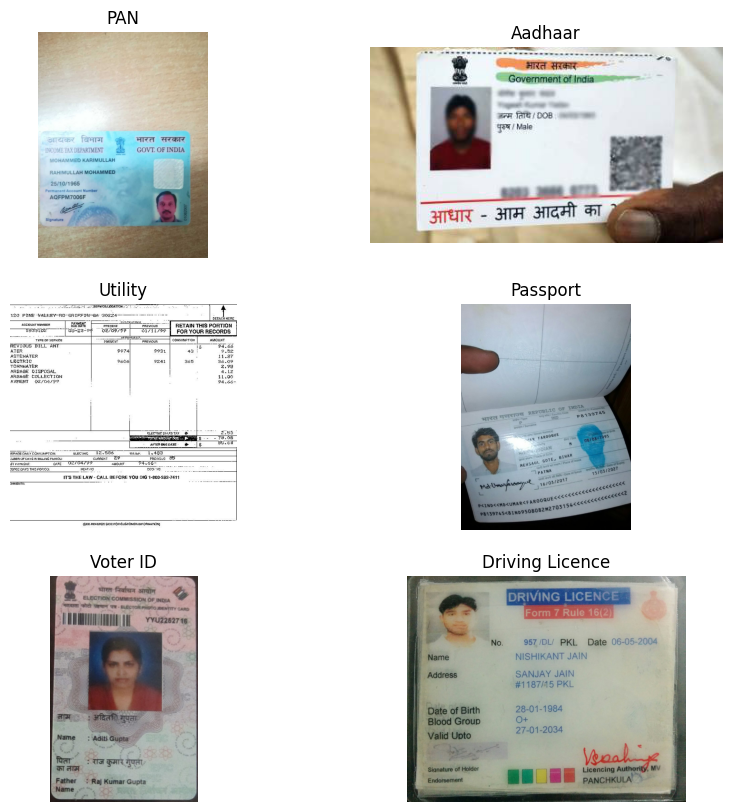

In [10]:
# visualizing a sample from each class

rows,cols,c=3,2,0

_, axs = plt.subplots(rows, cols, figsize=(10,10))
classes = os.listdir(parent_dir)

for i in range(rows*cols):
 img = imread(os.path.join(parent_dir, classes[i], os.listdir(os.path.join(parent_dir, classes[i]))[1]))
 axs[c//cols][c%cols].imshow(img, cmap="gray")
 axs[c//cols][c%cols].set_axis_off()
 axs[c//cols][c%cols].set_title(classes[i])
 c+=1
plt.show()


Some of the images in the dataset are corrupt so we are removing them.

In [11]:
def data_cleaning(parent_dir):
  for class_ in os.listdir(parent_dir):
    for img in os.listdir(os.path.join(parent_dir, class_)):
      try:
        Image.open(os.path.join(parent_dir, class_, img))
      except:
        print("Removing {}".format(os.path.join(parent_dir, class_, img)))
        os.remove(os.path.join(parent_dir, class_, img))

data_cleaning(parent_dir)

Removing /content/PIIDataset/Aadhaar/93.jpg
Removing /content/PIIDataset/Utility/53.jpg
Removing /content/PIIDataset/Utility/86.jpg
Removing /content/PIIDataset/Passport/69.jpg
Removing /content/PIIDataset/Driving Licence/41.jpg


In [12]:
! rm -r /content/PIIDataset/Utility    # removing utility class from the dataset

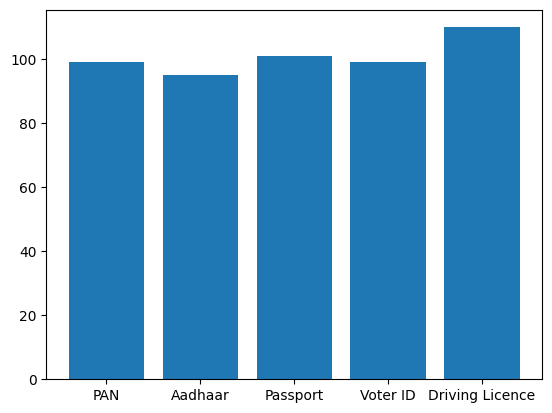

In [14]:
# frequency of the classes

classes = os.listdir(parent_dir)
frequency_classes = [len(os.listdir(os.path.join(parent_dir, class_))) for class_ in classes]
plt.bar(classes, frequency_classes)
plt.show()

The classes are uniformly distributed.

## Model Training and Evaluation

We use the ImageDataGenerator class to load the dataset from the folders, apply some transformations on them and create batches on the fly.

In [17]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                          horizontal_flip=True,
                                                          zoom_range=0.2,
                                                          rotation_range=30,
                                                          brightness_range=(0.5,1.5),
                                                          channel_shift_range=0.8,
                                                          validation_split=0.2)

In [18]:
train_generator = datagen.flow_from_directory(directory=parent_dir,
                                              target_size=(WIDTH, HEIGHT),
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              shuffle=True,
                                              seed=0,
                                              subset="training")
val_generator = datagen.flow_from_directory(directory=parent_dir,
                                              target_size=(WIDTH, HEIGHT),
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              shuffle=True,
                                              seed=0,
                                              subset="validation")

Found 405 images belonging to 5 classes.
Found 99 images belonging to 5 classes.


### Model Architecture

To create our model, we use the Sequential API from TensorFlow. The model has the following architecture:

- The first layer is a convolution layer that has 32 filters of size 3x3, relu activation, same padding and accepts input of shape (224, 224, 3).
- The second layer is again a convolution layer having 64 filters of size 3x3, relu activation, same padding and max-pooling with filter size of 2x2 and strides 2.
- The third and the final convolution layer has 128 filters of size 3x3, relu activation, same padding and max-pooling with filter size of 2x2 and strides 2. Finally, there is a flatten layer to flatten the output.
- The final layer of the model is again a dense layer with 5 units and linear activation to get the unnormalized outputs.

In [109]:
simple_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(WIDTH, HEIGHT, 3)),     
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=n_classes, activation='linear')
], name = "model1")

In [110]:
simple_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [111]:
simple_model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 flatten_18 (Flatten)        (None, 401408)            0    

In [112]:
history = simple_model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=50)

Epoch 1/50
26/26 [==============================] - 16s 574ms/step - loss: 3.2135 - accuracy: 0.2148 - val_loss: 1.6064 - val_accuracy: 0.2323
Epoch 2/50
26/26 [==============================] - 13s 502ms/step - loss: 1.6345 - accuracy: 0.3111 - val_loss: 1.6041 - val_accuracy: 0.2424
Epoch 3/50
26/26 [==============================] - 13s 508ms/step - loss: 1.6155 - accuracy: 0.2321 - val_loss: 1.6075 - val_accuracy: 0.2323
Epoch 4/50
26/26 [==============================] - 13s 507ms/step - loss: 1.5966 - accuracy: 0.2593 - val_loss: 1.5867 - val_accuracy: 0.3131
Epoch 5/50
26/26 [==============================] - 13s 504ms/step - loss: 1.5211 - accuracy: 0.3753 - val_loss: 1.5468 - val_accuracy: 0.3232
Epoch 6/50
26/26 [==============================] - 13s 505ms/step - loss: 1.5449 - accuracy: 0.3012 - val_loss: 1.5294 - val_accuracy: 0.3535
Epoch 7/50
26/26 [==============================] - 13s 506ms/step - loss: 1.3229 - accuracy: 0.4346 - val_loss: 1.2902 - val_accuracy: 0.4848

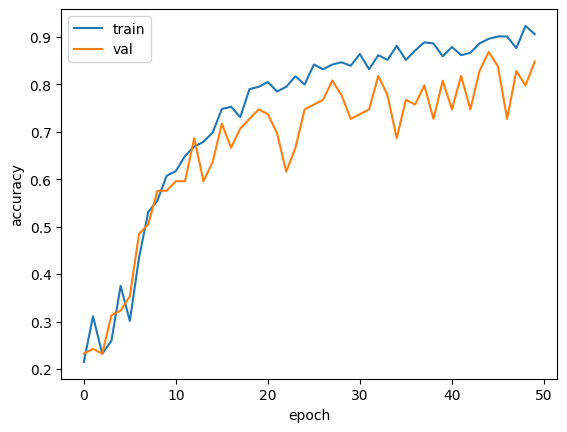

In [113]:
# accuracy plot

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

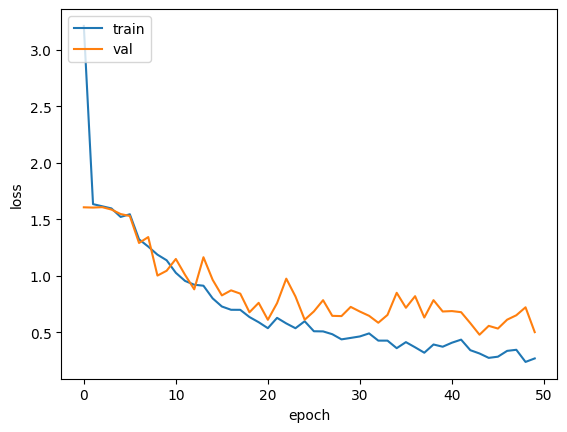

In [114]:
# loss plot

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We tried 5 different architectures and of those 5 architectures, this is the best model. The performance of even this model is not that good.

We try transfer learning with VGG16 as the base model to train another model and compare the performance.

In [115]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [116]:
vgg = VGG16(input_shape = (224,224,3), weights = 'imagenet', include_top = False)
for layer in vgg.layers:
  layer.trainable = False

x = tf.keras.layers.Flatten()(vgg.output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x) 
x = tf.keras.layers.Dense(64, activation = 'relu')(x) 
x = tf.keras.layers.Dense(5, activation = 'linear')(x) 
model = Model(inputs = vgg.input, outputs = x)

In [117]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [118]:
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [119]:
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)

Epoch 1/10
26/26 [==============================] - 15s 510ms/step - loss: 1.3477 - accuracy: 0.5432 - val_loss: 0.6377 - val_accuracy: 0.7475
Epoch 2/10
26/26 [==============================] - 13s 509ms/step - loss: 0.4492 - accuracy: 0.8593 - val_loss: 0.3331 - val_accuracy: 0.9091
Epoch 3/10
26/26 [==============================] - 13s 508ms/step - loss: 0.2968 - accuracy: 0.9185 - val_loss: 0.3268 - val_accuracy: 0.8788
Epoch 4/10
26/26 [==============================] - 13s 506ms/step - loss: 0.2236 - accuracy: 0.9358 - val_loss: 0.2403 - val_accuracy: 0.9192
Epoch 5/10
26/26 [==============================] - 13s 509ms/step - loss: 0.2823 - accuracy: 0.8914 - val_loss: 0.2678 - val_accuracy: 0.8990
Epoch 6/10
26/26 [==============================] - 13s 520ms/step - loss: 0.2093 - accuracy: 0.9160 - val_loss: 0.2317 - val_accuracy: 0.9293
Epoch 7/10
26/26 [==============================] - 13s 510ms/step - loss: 0.1121 - accuracy: 0.9654 - val_loss: 0.2726 - val_accuracy: 0.9192

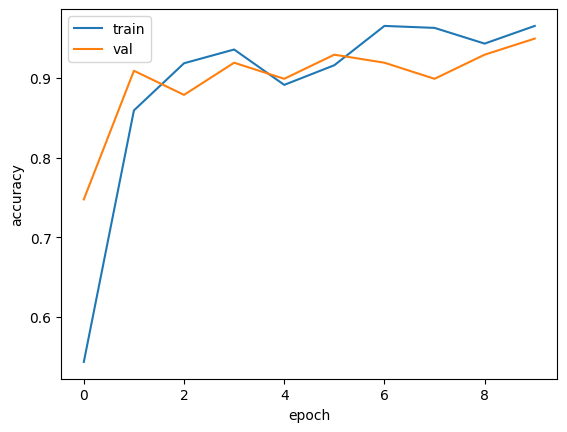

In [120]:
# accuracy plot

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

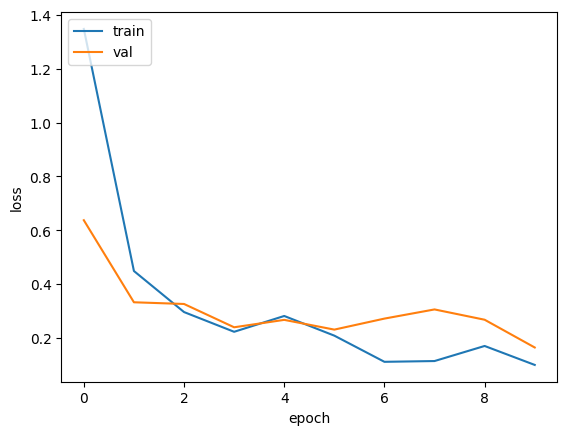

In [121]:
# loss plot

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The performance of the transfer learning based model is quite good. It is able to get good training and validation accuracies in just 10 epochs.